# LDA and Document Similarity

* [Referência: https://www.kaggle.com/ktattan/lda-and-document-similarity](https://www.kaggle.com/ktattan/lda-and-document-similarity)

In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import gensim
from gensim.models import LdaModel
from gensim import models, corpora, similarities
import re
from nltk.stem.porter import PorterStemmer
import time
from nltk import FreqDist
from scipy.stats import entropy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

/home/helder/estudos/tcc-pucmg-2/src/python/tcc-venv/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
df = pd.read_csv('fake.csv', usecols=['uuid','author','title','text','language','site_url','country'])
df = df[df.language == 'english']
df = df[df['text'].map(type) == str]
df['title'].fillna(value="", inplace=True)
df.dropna(axis=0, inplace=True, subset=['text'])

# shuffle the data
df = df.sample(frac=1.0)
df.reset_index(drop=True, inplace=True)
df.head()

,uuid,author,title,text,language,site_url,country
0,599e5248eb21ba4359525c00c69acf6f9a487585,NaN,Govt. of India And Orissa: Act Now: Prevent Ch...,NAPM condemns state and ‘expert’ apathy on dea...,english,countercurrents.org,SG
1,45dbe5260850da0a96c9b8b294bd5917a415c658,Nos Nevets,Re: ‘It’s for my children and grandchildren.’;...,‘It’s for my children.’; Ammon Bundy’s testimo...,english,twitchy.com,US
2,9ae42955a1e8739978d01863ebc6111e9a560a88,dailouk,Ignore Farage at Your Own Peril,Home | World | Ignore Farage at Your Own Peril...,english,dailysquib.co.uk,GB
3,e2b1017e29c15d416917c339d3c95ccd68688e82,Dr. Eowyn,184 U.S. generals and admirals endorse Trump f...,Have you seen that pro-Hillary TV ad of disgra...,english,dcclothesline.com,US
4,a34a4414c65b8c1fcd079b8a0b540def435ab52d,Joel Wickwire,South Africa to Withdraw From International Cr...,"On Thursday, Nov. 3, 2016, Tshililo Michael Ma...",english,guardianlv.com,US


In [3]:
def initial_clean(text):
    text = re.sub("((\S+)?(http(s)?)(\S+))|((\S+)?(www)(\S+))|((\S+)?(\@)(\S+)?)", " ", text)
    text = re.sub("[^a-zA-Z ]", "", text)
    text = text.lower() # lower case the text
    text = nltk.word_tokenize(text)
    return text

stop_words = stopwords.words('english')
def remove_stop_words(text):
    """
    Function that removes all stopwords from text
    """
    return [word for word in text if word not in stop_words]

stemmer = PorterStemmer()
def stem_words(text):
    """
    Function to stem words, so plural and singular are treated the same
    """
    try:
        text = [stemmer.stem(word) for word in text]
        text = [word for word in text if len(word) > 1] # make sure we have no 1 letter words
    except IndexError: # the word "oed" broke this, so needed try except
        pass
    return text

def apply_all(text):
    """
    This function applies all the functions above into one
    """
    return stem_words(remove_stop_words(initial_clean(text)))

In [4]:
# Run once
# nltk.download('punkt')

In [5]:
# clean text and title and create new column "tokenized"
t1 = time.time()
df['tokenized'] = df['text'].apply(apply_all) + df['title'].apply(apply_all)
t2 = time.time()
print("Time to clean and tokenize", len(df), "articles:", (t2-t1)/60, "min")

Time to clean and tokenize 12357 articles: 2.76176434357961 min


## Get word frequency

In [6]:
# first get a list of all words
all_words = [word for item in list(df['tokenized']) for word in item]
# use nltk fdist to get a frequency distribution of all words
fdist = FreqDist(all_words)
len(fdist) # number of unique words

96280


k = 50,000 is too high, as the bottom words aren't even real words and are very rarely used (once in entire corpus)
k = 15,000 is much more reasonable as these have been used at least 13 times in the corpus


In [7]:
# choose k and visually inspect the bottom 10 words of the top k
k = 50000
top_k_words = fdist.most_common(k)
top_k_words[-10:]

[('collectiven', 1),
 ('gamesh', 1),
 ('offscreen', 1),
 ('danault', 1),
 ('seidenberg', 1),
 ('neofeud', 1),
 ('letzigrund', 1),
 ('arnd', 1),
 ('wiegmann', 1),
 ('fedro', 1)]

In [8]:
# choose k and visually inspect the bottom 10 words of the top k
k = 15000
top_k_words = fdist.most_common(k)
top_k_words[-10:]

[('allbusi', 13),
 ('kilpatrick', 13),
 ('antidiscrimin', 13),
 ('corporatocraci', 13),
 ('mannequin', 13),
 ('gubernatori', 13),
 ('hanson', 13),
 ('rebutt', 13),
 ('ff', 13),
 ('muallem', 13)]

In [9]:
# define a function only to keep words in the top k words
top_k_words,_ = zip(*fdist.most_common(k))
top_k_words = set(top_k_words)
def keep_top_k_words(text):
    return [word for word in text if word in top_k_words]

In [10]:
df['tokenized'] = df['tokenized'].apply(keep_top_k_words)

In [11]:
# document length
df['doc_len'] = df['tokenized'].apply(lambda x: len(x))
doc_lengths = list(df['doc_len'])
df.drop(labels='doc_len', axis=1, inplace=True)

print("length of list:",len(doc_lengths),
      "\naverage document length", np.average(doc_lengths),
      "\nminimum document length", min(doc_lengths),
      "\nmaximum document length", max(doc_lengths))

length of list: 12357 
average document length 345.66828518248764 
minimum document length 0 
maximum document length 11578


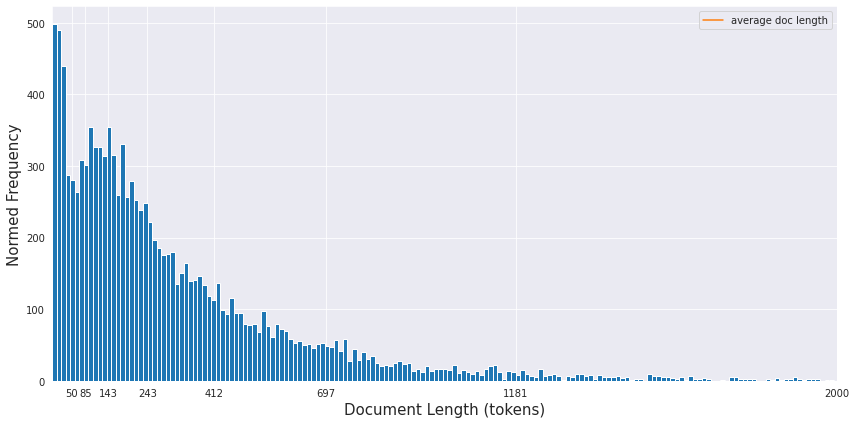

In [12]:
# plot a histogram of document length
num_bins = 1000
fig, ax = plt.subplots(figsize=(12,6))
# the histogram of the data
# n, bins, patches = ax.hist(doc_lengths, num_bins, normed=1)
n, bins, patches = ax.hist(doc_lengths, num_bins)
ax.set_xlabel('Document Length (tokens)', fontsize=15)
ax.set_ylabel('Normed Frequency', fontsize=15)
ax.grid()
ax.set_xticks(np.logspace(start=np.log10(50),stop=np.log10(2000),num=8, base=10.0))
plt.xlim(0,2000)
ax.plot([np.average(doc_lengths) for i in np.linspace(0.0,0.0035,100)], np.linspace(0.0,0.0035,100), '-',
        label='average doc length')
ax.legend()
ax.grid()
fig.tight_layout()
plt.show()

### Drop short articles

LDA does not work very well on short documents, which we will explain later, so we will drop some of the shorter articles here before training the model.

From the histogram above, droping all articles less than 40 tokens seems appropriate.

In [13]:
print("Before cleaning and excluding short aticles, the dataframe has:", len(df), "articles")
# only keep articles with more than 30 tokens, otherwise too short
df = df[df['tokenized'].map(len) >= 40]
# make sure all tokenized items are lists
df = df[df['tokenized'].map(type) == list]
df.reset_index(drop=True,inplace=True)
print("After cleaning and excluding short aticles, the dataframe now has:", len(df), "articles")

Before cleaning and excluding short aticles, the dataframe has: 12357 articles
After cleaning and excluding short aticles, the dataframe now has: 10812 articles


### Split the corpus into training ant testing

Here we will split the corpus into training and testing sets.

The training set will be used to train the LDA model on, while the testing set will be used to retrieve similar articles later in our recommendation algorithm.

The dataframe is already shuffled from the begining, so no need to do it again.

In [14]:
# create a mask of binary values
msk = np.random.rand(len(df)) < 0.999

train_df = df[msk]
train_df.reset_index(drop=True,inplace=True)

test_df = df[~msk]
test_df.reset_index(drop=True,inplace=True)

In [15]:
print(len(df),len(train_df),len(test_df))

10812 10795 17


In [16]:
def train_lda(data):
    """
    This function trains the lda model
    We setup parameters like number of topics, the chunksize to use in Hoffman method
    We also do 2 passes of the data since this is a small dataset, so we want the distributions to stabilize
    """
    num_topics = 100
    chunksize = 300
    dictionary = corpora.Dictionary(data['tokenized'])
    corpus = [dictionary.doc2bow(doc) for doc in data['tokenized']]
    t1 = time.time()
    # low alpha means each document is only represented by a small number of topics, and vice versa
    # low eta means each topic is only represented by a small number of words, and vice versa
    lda = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary,
                   alpha=1e-2, eta=0.5e-2, chunksize=chunksize, minimum_probability=0.0, passes=2)
    t2 = time.time()
    print("Time to train LDA model on ", len(df), "articles: ", (t2-t1)/60, "min")
    return dictionary,corpus,lda

In [17]:
dictionary,corpus,lda = train_lda(train_df)

Time to train LDA model on  10812 articles:  2.9911104798316956 min


### Let's inspect some topics!

Bear in mind, when we see the words they may seem shortened. Recall this is because of our stemming function we previously implemented.

In [18]:
# show_topics method shows the the top num_words contributing to num_topics number of random topics
lda.show_topics(num_topics=10, num_words=20)

[(2,
  '0.070*"china" + 0.031*"chines" + 0.018*"south" + 0.016*"year" + 0.016*"countri" + 0.016*"trade" + 0.016*"asia" + 0.013*"us" + 0.013*"region" + 0.012*"japan" + 0.011*"world" + 0.009*"tpp" + 0.009*"sea" + 0.008*"pacif" + 0.008*"asian" + 0.008*"east" + 0.007*"island" + 0.007*"last" + 0.007*"beij" + 0.007*"free"'),
 (29,
  '0.022*"class" + 0.020*"parti" + 0.016*"democrat" + 0.014*"corpor" + 0.013*"street" + 0.012*"progress" + 0.012*"care" + 0.012*"social" + 0.011*"left" + 0.011*"american" + 0.010*"system" + 0.010*"insur" + 0.010*"work" + 0.010*"obamacar" + 0.010*"polit" + 0.010*"peopl" + 0.010*"health" + 0.009*"wall" + 0.009*"wage" + 0.009*"rule"'),
 (11,
  '0.017*"even" + 0.013*"polit" + 0.008*"like" + 0.008*"evil" + 0.007*"might" + 0.007*"debat" + 0.006*"reason" + 0.005*"actual" + 0.005*"one" + 0.005*"view" + 0.005*"could" + 0.005*"lesser" + 0.005*"seem" + 0.005*"champion" + 0.004*"would" + 0.004*"support" + 0.004*"write" + 0.004*"cohen" + 0.004*"inde" + 0.004*"remark"'),
 (84,
 

In [19]:
lda.show_topic(topicid=4, topn=20)

[('war', 0.05864983),
 ('us', 0.04769018),
 ('syria', 0.039473593),
 ('iran', 0.020451374),
 ('russia', 0.014680034),
 ('would', 0.01424361),
 ('militari', 0.01283171),
 ('state', 0.011925456),
 ('iraq', 0.011159249),
 ('polici', 0.011005993),
 ('syrian', 0.0105024455),
 ('world', 0.008618988),
 ('obama', 0.0085997535),
 ('zone', 0.008210824),
 ('foreign', 0.0077317944),
 ('unit', 0.007472299),
 ('east', 0.0069010197),
 ('presid', 0.006340187),
 ('washington', 0.006302181),
 ('assad', 0.0062539396)]

In [20]:
lda.show_topic(topicid=85, topn=20)

[('clinton', 0.09075888),
 ('hillari', 0.033943832),
 ('bill', 0.021646313),
 ('foundat', 0.018514164),
 ('presid', 0.012274687),
 ('campaign', 0.011753728),
 ('million', 0.011039577),
 ('assang', 0.010674704),
 ('secretari', 0.009048453),
 ('state', 0.008736669),
 ('money', 0.007910643),
 ('email', 0.007327688),
 ('former', 0.00702248),
 ('kadzik', 0.0065720524),
 ('john', 0.006460049),
 ('also', 0.0063725226),
 ('podesta', 0.0060553784),
 ('donat', 0.0057077548),
 ('julian', 0.0054872134),
 ('wikileak', 0.005207423)]

In [21]:
lda.show_topic(topicid=75, topn=20)

[('abort', 0.02669792),
 ('religion', 0.022716762),
 ('women', 0.020536395),
 ('gay', 0.019256508),
 ('sexual', 0.017198289),
 ('marriag', 0.017055742),
 ('jesu', 0.016263926),
 ('bee', 0.015666096),
 ('christ', 0.015270552),
 ('jay', 0.013100014),
 ('cuban', 0.009936154),
 ('run', 0.009921837),
 ('cuba', 0.009314745),
 ('ny', 0.008841748),
 ('evangel', 0.008403458),
 ('jihad', 0.008378848),
 ('gingrich', 0.008253588),
 ('hemp', 0.008176903),
 ('gospel', 0.007980819),
 ('end', 0.007846244)]

In [22]:
lda.show_topic(topicid=39, topn=20)

[('trump', 0.048000388),
 ('clinton', 0.03848722),
 ('elect', 0.02901784),
 ('hillari', 0.0281196),
 ('democrat', 0.02365923),
 ('republican', 0.023501944),
 ('candid', 0.019511824),
 ('vote', 0.018211523),
 ('campaign', 0.014100726),
 ('donald', 0.013769234),
 ('presidenti', 0.013571008),
 ('parti', 0.013049867),
 ('win', 0.012755329),
 ('state', 0.012227529),
 ('poll', 0.012120867),
 ('voter', 0.01143731),
 ('support', 0.01095005),
 ('presid', 0.010733614),
 ('would', 0.009602449),
 ('elector', 0.007016963)]

What the about above means, is that topic 4 has top contributing words ["judge","case","court",...], which indicates the topic is about court cases. Topic 75 has top contributing words ["god","christian","love",...], which indicates the topic is about religion.

Now, not only can we see the word contribution for each topic, but we can also visualise the topic contribution for each article.

In [23]:
# select and article at random from train_df
random_article_index = np.random.randint(len(train_df))
bow = dictionary.doc2bow(train_df.iloc[random_article_index,7])
print(random_article_index)

4820


In [24]:
print(train_df.iloc[random_article_index,3])


As of October 29, there have been at least 141 arrests of peaceful protesters at the Standing Rock Reservation who are attempting to stop the Dakota Access Pipeline (DAPL), which poses a major threat to the drinking water of all people at Standing Rock.
Paid for by Energy Transfer Partners , parent company to Dakota Access LLC, the DAPL is set to be embedded in a sacred burial ground at Standing Rock. This is the same area where DAPL security used attack dogs on peaceful people to intimidate protesters. Police snipers were seen peaking out of armored vehicles, aiming directly at unarmed protesters.
These water protectors have been brutalized by officers who are using the color of law to help Dakota Access LLC trample on the the 1851 treaty between the US and the Cheyenne, Sioux, Arapaho, Crow, Assiniboine, Mandan, Hidatsa, and Arikara nations.

Protesters who were arrested had handcuffs or zipties placed fixed to their wrists, they were stuffed into cages made for dogs and over-crowde

In [25]:
# get the topic contributions for the document chosen at random above
doc_distribution = np.array([tup[1] for tup in lda.get_document_topics(bow=bow)])

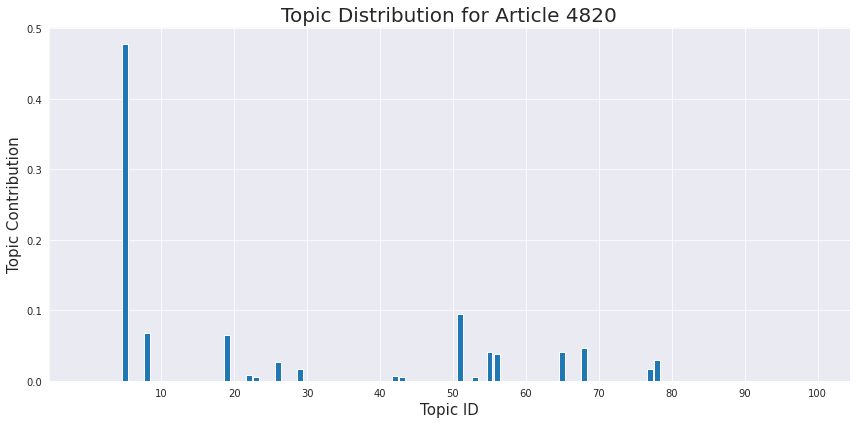

In [26]:
# bar plot of topic distribution for this document
fig, ax = plt.subplots(figsize=(12,6));
# the histogram of the data
patches = ax.bar(np.arange(len(doc_distribution)), doc_distribution)
ax.set_xlabel('Topic ID', fontsize=15)
ax.set_ylabel('Topic Contribution', fontsize=15)
ax.set_title("Topic Distribution for Article " + str(random_article_index), fontsize=20)
ax.set_xticks(np.linspace(10,100,10))
fig.tight_layout()
plt.show()

Ok, so clearly this document has various contributions from different topics. But what are these topics? Lets find out!

In [27]:
# print the top 5 contributing topics and their words
for i in doc_distribution.argsort()[-5:][::-1]:
    print(i, lda.show_topic(topicid=i, topn=10), "\n")

5 [('pipelin', 0.04031538), ('protest', 0.038482532), ('stand', 0.028718835), ('dakota', 0.02714859), ('rock', 0.021430142), ('water', 0.020183163), ('land', 0.01836647), ('north', 0.017447902), ('nativ', 0.01723893), ('access', 0.016089967)] 

51 [('polic', 0.08254971), ('offic', 0.045712095), ('muslim', 0.032205228), ('kill', 0.023441894), ('fire', 0.018745039), ('cop', 0.015915753), ('shot', 0.015438874), ('said', 0.014733963), ('shoot', 0.012652351), ('attack', 0.010649086)] 

8 [('one', 0.013433766), ('time', 0.01014289), ('make', 0.0071112383), ('mani', 0.006212977), ('need', 0.006137973), ('way', 0.005896817), ('use', 0.0058598653), ('would', 0.0056478158), ('could', 0.0053667203), ('see', 0.005132072)] 

19 [('health', 0.037748564), ('diseas', 0.019721972), ('effect', 0.017670015), ('increas', 0.016377527), ('studi', 0.012460072), ('reduc', 0.011761358), ('risk', 0.011609167), ('caus', 0.011359086), ('brain', 0.010503513), ('product', 0.010065087)] 

68 [('drug', 0.08448553), (

## Similarity Queries and Unseen Data

First, lets show how we can infer document topics for a new unseen article.

In [28]:
# select and article at random from test_df
random_article_index = np.random.randint(len(test_df))
print(random_article_index)                                                                                                               

3


Here's the important bit. In obtaining the BOW representation for this unseen article, gensim cleverly only considers words in the existing dictionary we used to train the model. So if there are new words in this article, they will not be considered when infering the topic distribution. This is good in that no errors arise for unseen words, but bad in that some words may be cut out, and therefore we could miss out on an accurate topic distribution for this article.

In [29]:
new_bow = dictionary.doc2bow(test_df.iloc[random_article_index,7])

In [31]:
print(test_df.iloc[random_article_index,3])

in: General Health There are a number of reasons it’s important to get adequate amounts of folic acid. Perhaps most importantly are cellular growth and regeneration. A recent article from the New York Times fingered folic acid as one of the most, “luscious micronutrients” available and multiple studies suggest a lack of folic acid may lead to mental conditions such as depression. Folic acid allows the body to perform many essential functions including nucleotide biosynthesis in cells, DNA synthesis and repair, red blood cell creation, and prevention of anemia. Folic acid, also known as vitamin B9, is well known for its application in the prevention of fetal deformities, Alzheimer’s disease, and several types of cancer. Fortunately, there are many foods that are naturally rich sources of folic acid. Folic Acid vs. Folate While folic acid and folate are often marketed as one and the same, their metabolic effects can be quite different. Folate is the bioavailable, natural form of vitamin 

In [32]:
new_doc_distribution = np.array([tup[1] for tup in lda.get_document_topics(bow=new_bow)])

Let's do the same visual analysis as before on this new unseen document

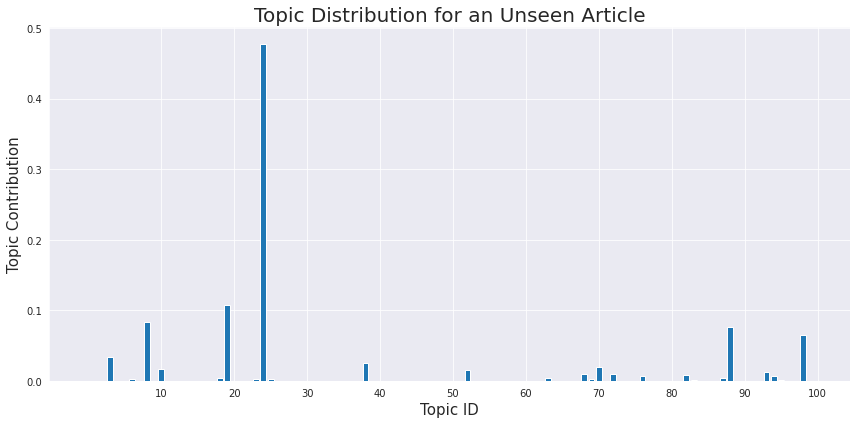

In [33]:
# bar plot of topic distribution for this document
fig, ax = plt.subplots(figsize=(12,6));
# the histogram of the data
patches = ax.bar(np.arange(len(new_doc_distribution)), new_doc_distribution)
ax.set_xlabel('Topic ID', fontsize=15)
ax.set_ylabel('Topic Contribution', fontsize=15)
ax.set_title("Topic Distribution for an Unseen Article", fontsize=20)
ax.set_xticks(np.linspace(10,100,10))
fig.tight_layout()
plt.show()

In [34]:
# print the top 8 contributing topics and their words
for i in new_doc_distribution.argsort()[-5:][::-1]:
    print(i, lda.show_topic(topicid=i, topn=10), "\n")

24 [('food', 0.07092561), ('water', 0.05767931), ('cancer', 0.041549653), ('plant', 0.021820731), ('eat', 0.019057285), ('also', 0.018100098), ('vitamin', 0.016854921), ('use', 0.015606366), ('contain', 0.013931586), ('milk', 0.013416977)] 

19 [('health', 0.037748564), ('diseas', 0.019721972), ('effect', 0.017670015), ('increas', 0.016377527), ('studi', 0.012460072), ('reduc', 0.011761358), ('risk', 0.011609167), ('caus', 0.011359086), ('brain', 0.010503513), ('product', 0.010065087)] 

8 [('one', 0.013433766), ('time', 0.01014289), ('make', 0.0071112383), ('mani', 0.006212977), ('need', 0.006137973), ('way', 0.005896817), ('use', 0.0058598653), ('would', 0.0056478158), ('could', 0.0053667203), ('see', 0.005132072)] 

88 [('bodi', 0.037770584), ('energi', 0.02794356), ('light', 0.014070433), ('pain', 0.012472475), ('help', 0.011592489), ('feel', 0.009425336), ('soul', 0.007379369), ('also', 0.007365782), ('process', 0.0073073492), ('sleep', 0.0072138957)] 

98 [('use', 0.022868242), (

### Similarity query

Ok, now that we have a topic distribution for a new unseen document, let's say we wanted to find the most similar documents in the corpus. We can do this by comparing the topic distribution of the new document to all the topic distributions of the documents in the corpus. We use the Jensen-Shannon distance metric to find the most similar documents.

What the Jensen-Shannon distance tells us, is which documents are statisically "closer" (and therefore more similar), by comparing the divergence of their distributions. Jensen-Shannon is symmetric, unlike Kullback-Leibler on which the formula is based. This is good, because we want the similarity between documents A and B to be the same as the similarity between B and A.

The smaller the Jensen-Shannon Distance, the more similar two distributions are (and in our case, the more similar any 2 documents are)

We can use the scipy implementation of entropy to do this. Entropy calculates the KL divergence.

But first, we need to get all our LDA topic distributions into a dense matrix. This will enable fast and efficient computation.

We will create a dense matrix, doc_topic_dist, of size M×K
where M is the number of documents and K is the number of topics.

In [37]:
# we need to use nested list comprehension here
# this may take 1-2 minutes...
doc_topic_dist = np.array([[tup[1] for tup in lst] for lst in lda[corpus]])
doc_topic_dist.shape

(10795, 100)

In [38]:
# Esta implementacao foi feita com uma versao antiga do scipy que comparava entradas do entropy usando len
# mas a versao nova usa shape e isso da erro nesta implementacao. Por este motivo foi
# feita a implementacao usando o metodo shannon_distance do scipy.spatial.distance
def jensen_shannon(query, matrix):
    """
    This function implements a Jensen-Shannon similarity
    between the input query (an LDA topic distribution for a document)
    and the entire corpus of topic distributions.
    It returns an array of length M where M is the number of documents in the corpus
    """
    # lets keep with the p,q notation above
    p = query[None,:].T # take transpose
    q = matrix.T # transpose matrix
    m = 0.5*(p + q)
    return np.sqrt(0.5*(entropy(p,m) + entropy(q,m)))

In [67]:
from scipy.spatial import distance
def jensen_shannon2(query, matrix):
    sim=[distance.jensenshannon(data,query) for data in matrix]
    return np.array(sim)

Let's compare the new unseen document, to the corpus, and see which articles are most similar.

In [65]:
def get_most_similar_documents(query,matrix,k=10):
    """
    This function implements the Jensen-Shannon distance above
    and retruns the top k indices of the smallest jensen shannon distances
    """
    sims = jensen_shannon2(query,matrix) # list of jensen shannon distances
    return sims.argsort()[:k] # the top k positional index of the smallest Jensen Shannon distances

Query time + most similar documents... at last!

Ok, let's be 100% clear about what we are doing here.

We are comparing the new unseen document above to the entire corpus of ~10k documents to find which one is most similar to the new document.

How are we doing that? Well, we have the new documents LDA topic distribution in stored as varibale new_doc_distribution, and we have the entire corpus of documents topic distributions stored in the dense matrix doc_topic_dist. So now, we pass each row of doc_topic_dist through the Jensen-Shannon function above as the Q distribution, while the P distribution remains static as new_doc_distribution. Then we get the smallest distances and their corresponding index in the array, which we can pass to the train_df dataframe to print out the most similar documents.

In [68]:
# this is surprisingly fast
most_sim_ids = get_most_similar_documents(new_doc_distribution,doc_topic_dist)

In [69]:
most_similar_df = train_df[train_df.index.isin(most_sim_ids)]
most_similar_df['title']

394                       How To Measure Water pH At Home
1033    Alkaline Water Kills Cancer – How to Make Your...
1873    Food mixology: When eaten together, these food...
3023    Comment on Why We’re All Deficient In Magnesiu...
4105             15 Foods That Contain The Most Vitamin E
5584    Comment on 4 of the Best Kinds of Milk That Ar...
6201    15 Foods That Contain the Most Vitamin E | Alt...
6650    Why Most People Are Deficient In Magnesium: Th...
6652        4 of the Best Kinds of Milk That Aren’t Dairy
8921    This Cilantro Recipe Can Remove 80% Of Heavy M...
Name: title, dtype: object

In [57]:
# this is surprisingly fast
# most_sim_ids = get_most_similar_documents(new_doc_distribution,doc_topic_dist)
# jensen_shannon(new_doc_distribution, doc_topic_dist)
p = new_doc_distribution[None,:].T # 100,1
q = doc_topic_dist.T # 100,10795
m = 0.5*(p+q) # 100, 10795

In [63]:
entropy(,m)

ValueError: qk and pk must have same shape.

### Análise de erro